In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import ssl; ssl._create_default_https_context = ssl._create_unverified_context
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sciRED import ensembleFCA as efca
from sciRED import glm
from sciRED import rotations as rot
from sciRED import metrics as met

from sciRED.utils import preprocess as proc
from sciRED.utils import visualize as vis
from sciRED.utils import corr
from sciRED.examples import ex_preprocess as exproc
from sciRED.examples import ex_visualize as exvis


/home/delaram/anaconda3/envs/sciRED/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(10)
NUM_COMPONENTS = 30
NUM_GENES = 2000
NUM_COMP_TO_VIS = 3

In [3]:
%%capture
data_file_path = '/home/delaram/sciRED/Data/scMix_3cl_merged.h5ad'
data = exproc.import_AnnData(data_file_path)
data, gene_idx = proc.get_sub_data(data, num_genes=NUM_GENES) # subset the data to num_genes HVGs
y, genes, num_cells, num_genes = proc.get_data_array(data)
y_cell_line, y_sample, y_protocol = exproc.get_metadata_scMix(data)

data.obs['protocol'] = y_protocol.to_numpy()
data.obs['cell_line'] = y_cell_line.to_numpy()
data.obs['sample'] = y_sample.to_numpy()

colors_dict_scMix = exvis.get_colors_dict_scMix(y_protocol, y_cell_line)
plt_legend_cell_line = exvis.get_legend_patch(y_cell_line, colors_dict_scMix['cell_line'] )
plt_legend_protocol = exvis.get_legend_patch(y_sample, colors_dict_scMix['protocol'] )

**Step 1: Factor discovery:** Since we are interested in sample-specific simulation signals, including _sample_ as a covariate inside GLM could remove interesting biological signals. Therefore, we only include library size in sciRED's design matrix to be regressed out. As explained in the manuscript, we recommend extracting the **pearson** residuals by default for later factor decompoisition. However, our benchmark analysis indicated that sciRED is not sensitive to choice of residual. Other options are _response_ and _deviance_ residual types.

One option for the design matrix is to only regress out library size: 
```x = proc.get_library_design_mat(data, lib_size='nCount_originalexp')```

However, as discussed in sciRED paper, it's recommended to also regress the _protocol_ covariate to improve the one-to-one association between factors and cell-line gene expression programs. 
Deciding which technical covariates need to be regressed using the GLM step is often not trivial. If a technical covariate is collinear with a biological signal of interest (such as _sample_ and _stimulation_ in the PBMC tutorial), we need to be cautious about its inclusion in the GLM model

In [4]:
#### Design matrix - including library size and protocol
x_protocol = proc.get_design_mat(metadata_col='protocol', data=data) 
x = np.column_stack((data.obs.nCount_originalexp, x_protocol)) 
x = sm.add_constant(x) ## adding the intercept

glm_fit_dict = glm.poissonGLM(y, x)
resid_pearson = glm_fit_dict['resid_pearson'] 
print('pearson residuals: ', resid_pearson.shape) # numpy array of shape (num_genes, num_cells)
print('y shape: ', y.shape) # (num_cells, num_genes)
y = resid_pearson.T # (num_cells, num_genes)
print('y shape: ', y.shape) # (num_cells, num_genes)

time to fit the model:  8.613743305206299
pearson residuals:  (2000, 1401)
y shape:  (1401, 2000)
y shape:  (1401, 2000)


We then apply PCA to the extracted residuals. PCA factors are then rotated (varimax or promax) to improve interpretibility. 

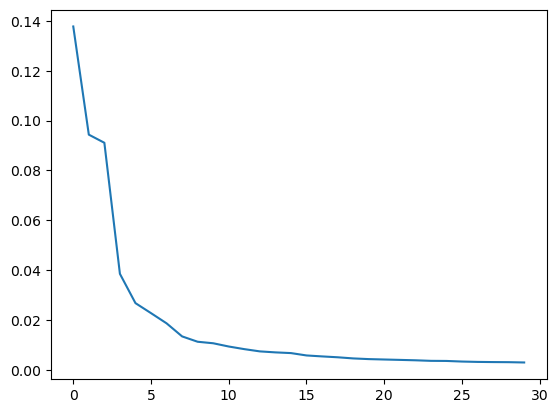

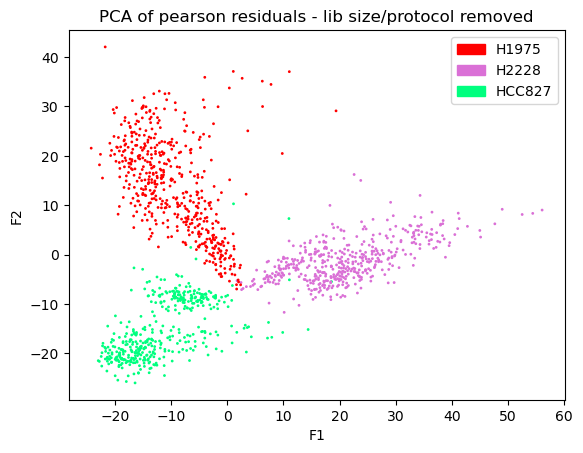

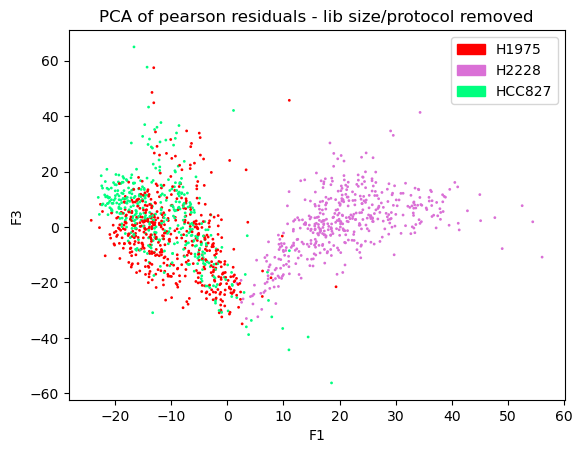

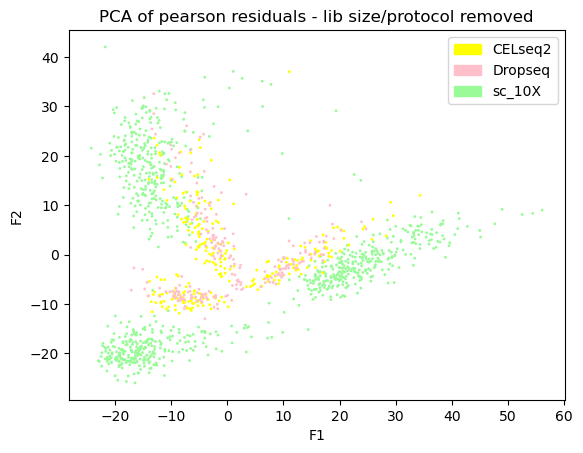

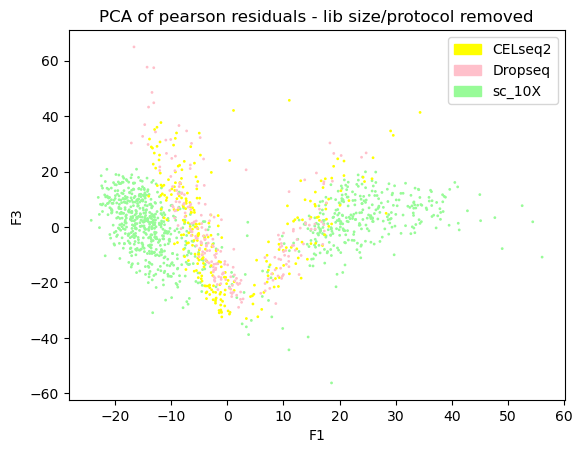

In [5]:
################################################
#### Running PCA on the pearson residual ######
################################################

### using pipeline to scale the gene expression data first
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=NUM_COMPONENTS))])
pca_scores = pipeline.fit_transform(y)
pca = pipeline.named_steps['pca']
pca_loading = pca.components_
pca_loading.shape
plt.plot(pca.explained_variance_ratio_)


title = 'PCA of pearson residuals - lib size/protocol removed'
### make a dictionary of colors for each sample in y_sample
vis.plot_pca(pca_scores, NUM_COMP_TO_VIS, 
               cell_color_vec= colors_dict_scMix['cell_line'], 
               legend_handles=True,
               title=title,
               plt_legend_list=plt_legend_cell_line)

### make a dictionary of colors for each sample in y_sample
vis.plot_pca(pca_scores, NUM_COMP_TO_VIS, 
               cell_color_vec= colors_dict_scMix['protocol'], 
               legend_handles=True,
               title=title,
               plt_legend_list=plt_legend_protocol)


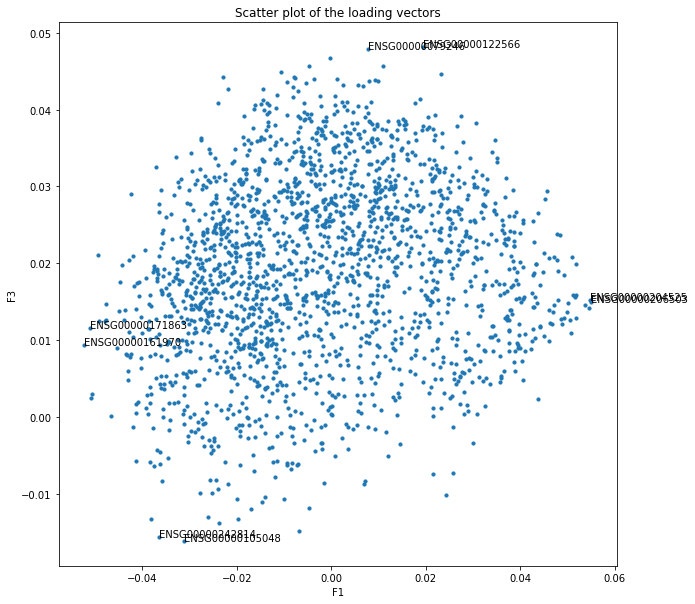

In [10]:
#### plot the loadings of the factors
vis.plot_factor_loading(pca_loading.T, genes, 0, 2, fontsize=10, 
                    num_gene_labels=2,
                    title='Scatter plot of the loading vectors', 
                    label_x=True, label_y=True)

embedding shape:  (1401, 2)


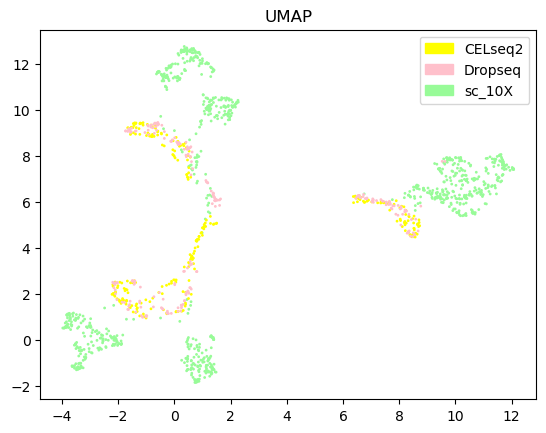

embedding shape:  (1401, 2)


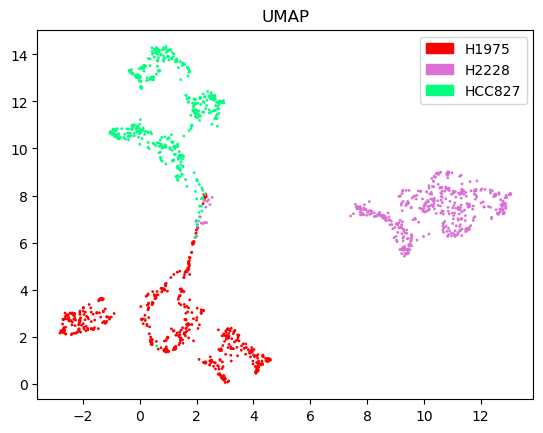

In [6]:
vis.plot_umap(pca_scores, 
              title='UMAP',
              cell_color_vec= colors_dict_scMix['protocol'] , 
               legend_handles=True,plt_legend_list=plt_legend_protocol)


vis.plot_umap(pca_scores, 
              title='UMAP',
              cell_color_vec= colors_dict_scMix['cell_line'] , 
               legend_handles=True,plt_legend_list=plt_legend_cell_line)


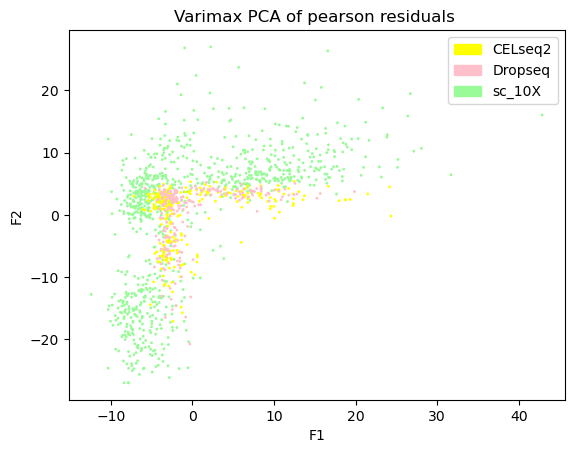

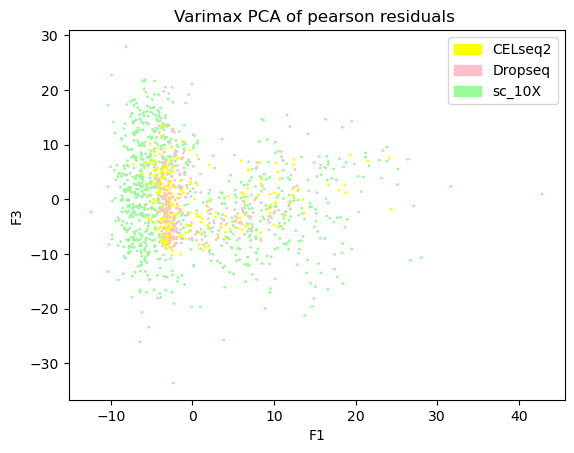

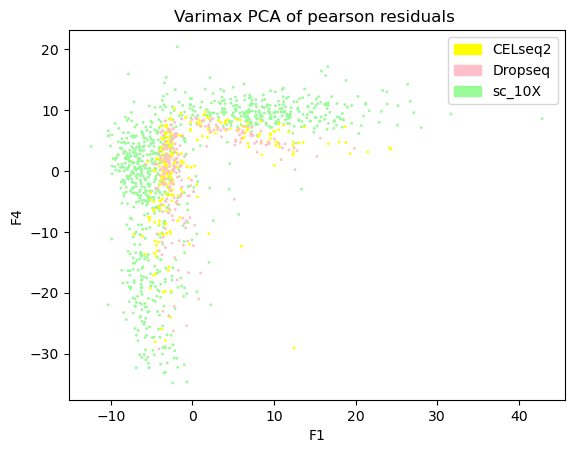

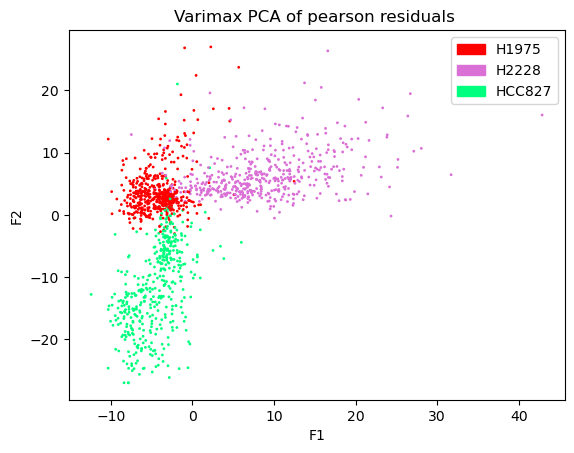

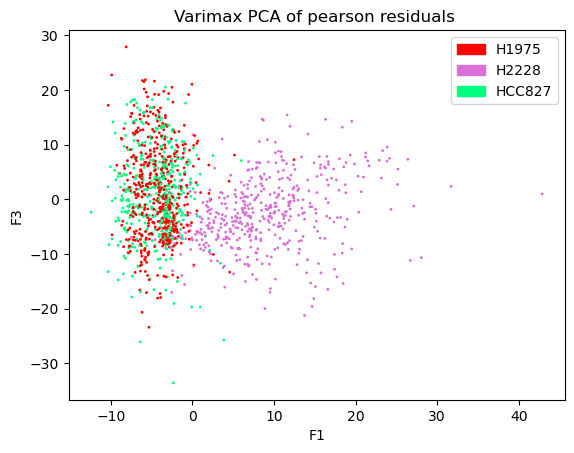

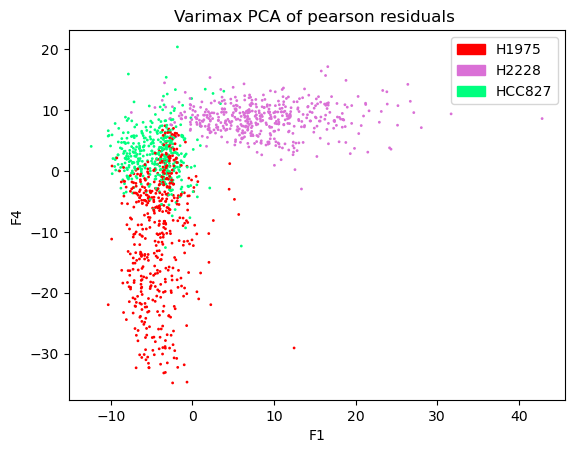

In [7]:
######## Applying varimax rotation to the factor scores
rotation_results_varimax = rot.varimax(pca_loading.T)
varimax_loading = rotation_results_varimax['rotloading']
pca_scores_varimax = rot.get_rotated_scores(pca_scores, rotation_results_varimax['rotmat'])

title = 'Varimax PCA of pearson residuals '

vis.plot_pca(pca_scores_varimax, NUM_COMP_TO_VIS+1, 
               cell_color_vec= colors_dict_scMix['protocol'], 
               legend_handles=True,
               title=title,
               plt_legend_list=plt_legend_protocol)

vis.plot_pca(pca_scores_varimax, NUM_COMP_TO_VIS+1, 
               cell_color_vec= colors_dict_scMix['cell_line'], 
               legend_handles=True,
               title=title,
               plt_legend_list=plt_legend_cell_line)

In [8]:
##### Setting the factor scores an loadings to be used in step-2 based on Varimax factors
factor_loading = rotation_results_varimax['rotloading']
factor_scores = pca_scores_varimax

**Step 2: Factor-Covariate Association**: To identify factors that explain a specific covariate, sciRED employs an ensemble classifier as a second step. We apply four machine learning classifiers to predict covariate labels based on the cell-specific factor weights. Feature importance scores are obtained from each classifier are then scaled based on one out of three scaling methods, and averaged to generate a consensus association score. The consensus scores for every combination of covariate and factor are aggregated into the factor-covariate association table (FCAT) and visualized in a heatmap. 
The FCAT function takes-in the cell-level labels for each covariate. The resulting tables for each covariate are then concatenated and visualized as a heatmap.  

In [9]:
%%capture
####################################
#### FCAT score calculation ######
####################################

### FCAT needs to be calculated for each covariate separately
fcat_protocol = efca.FCAT(y_protocol, factor_scores, scale='standard', mean='arithmatic')
fcat_cell_line = efca.FCAT(y_cell_line, factor_scores, scale='standard', mean='arithmatic')

### concatenate FCAT table for protocol and cell line
fcat = pd.concat([fcat_protocol, fcat_cell_line], axis=0)


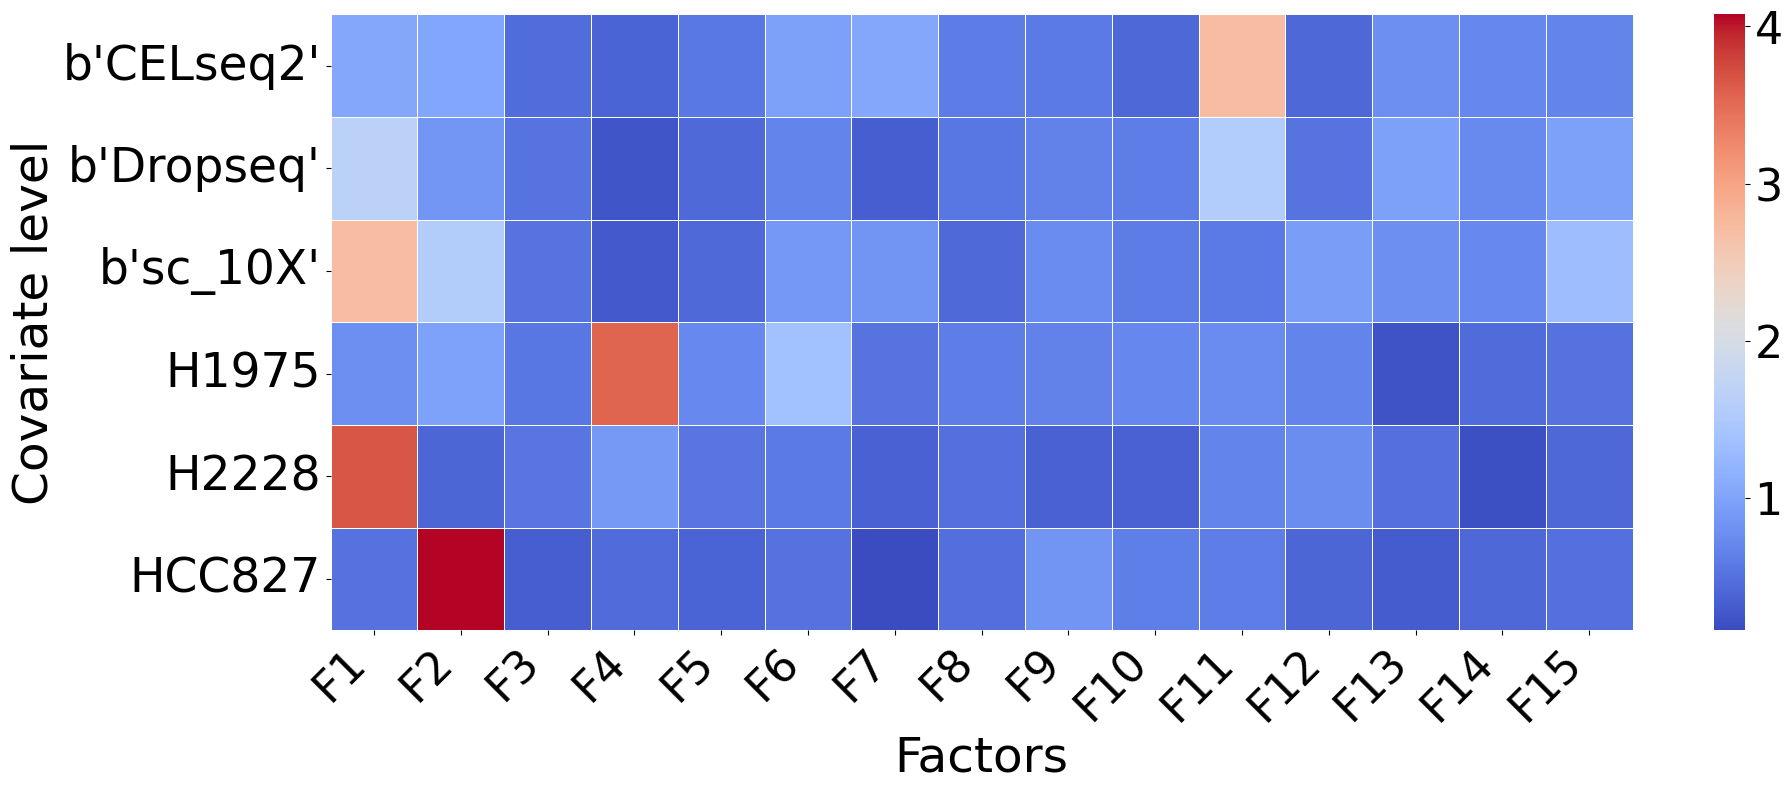

In [10]:
### visualize the first 15 factors
vis.plot_FCAT(fcat.iloc[:,0:15],title='', color='coolwarm',x_axis_fontsize=35, 
              y_axis_fontsize=35, title_fontsize=35,
              x_axis_tick_fontsize=32, y_axis_tick_fontsize=34)

Significant vs non-significant associations between factors and covariates are determined using a threshold automatically obtained using Otsu’s method. This threshold can assist users in defining the number of inferred factors (K). For example, if a considerable proportion of factors fail to align with any covariates, it may prompt the user to reduce K. 

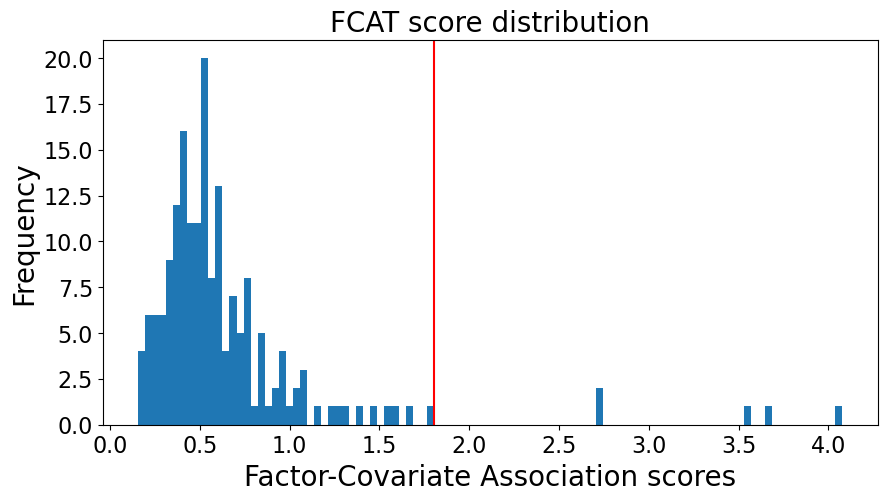

In [12]:

## rownames of the FCAT table
all_covariate_levels = fcat.index.values

### using Otsu's method to calculate the threshold
threshold = efca.get_otsu_threshold(fcat.values.flatten())

vis.plot_histogram(fcat.values.flatten(),
                   xlabel='Factor-Covariate Association scores',
                   title='FCAT score distribution',
                   threshold=threshold)



percent_matched_fact:  13.33
percent_matched_cov:  83.33


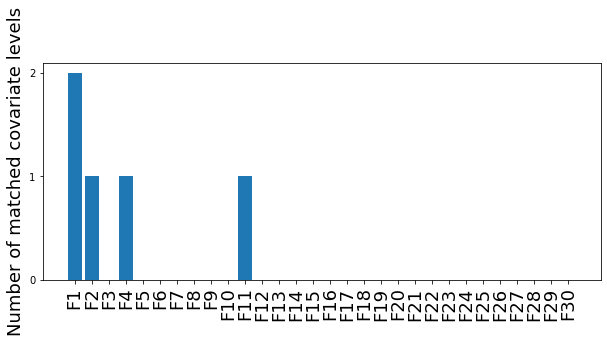

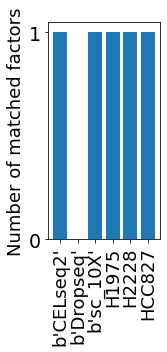

In [22]:

matched_factor_dist, percent_matched_fact = efca.get_percent_matched_factors(fcat, threshold)
matched_covariate_dist, percent_matched_cov = efca.get_percent_matched_covariates(fcat, threshold=threshold)

print('percent_matched_fact: ', percent_matched_fact)
print('percent_matched_cov: ', percent_matched_cov)
vis.plot_matched_factor_dist(matched_factor_dist)
vis.plot_matched_covariate_dist(matched_covariate_dist, 
                                covariate_levels=all_covariate_levels)



We can check the correlation between the factors and the library size which was regressed out

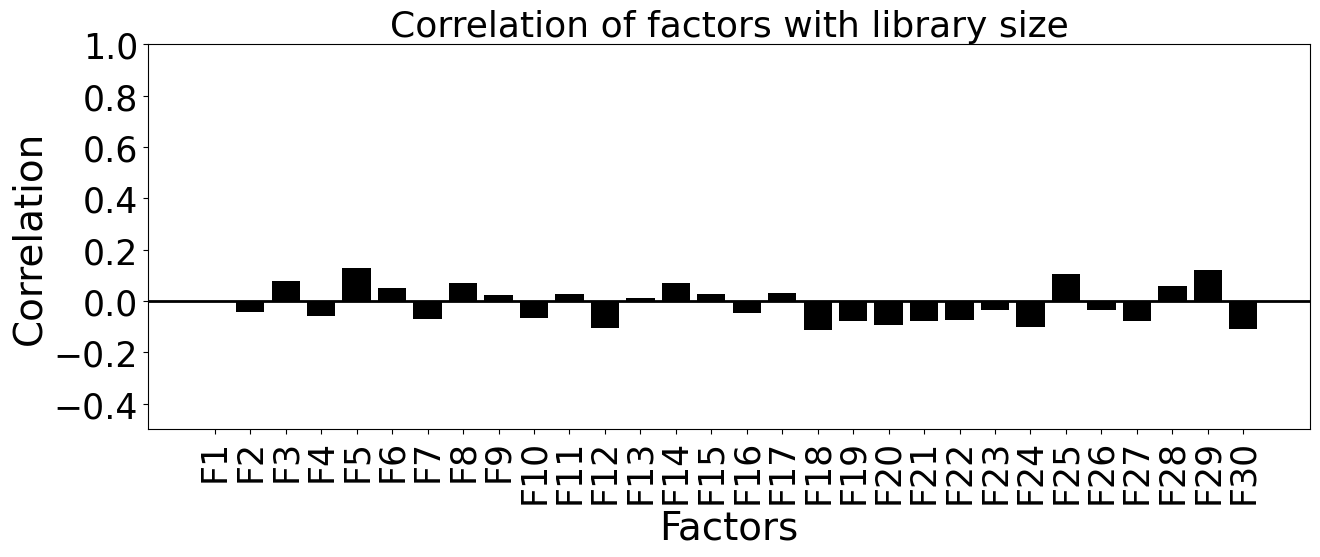

In [13]:

factor_libsize_correlation = corr.get_factor_libsize_correlation(factor_scores, library_size = data.obs.nCount_originalexp)
vis.plot_factor_cor_barplot(factor_libsize_correlation, 
             title='Correlation of factors with library size', 
             y_label='Correlation', x_label='Factors')


**Step 3: Interpretability scores:** The third step of sciRED involves quantifying the interpretability of identified factors. We defined four categories of metrics: separability, effect size, specificity, and homogeneity which are presented as the FIST table. 

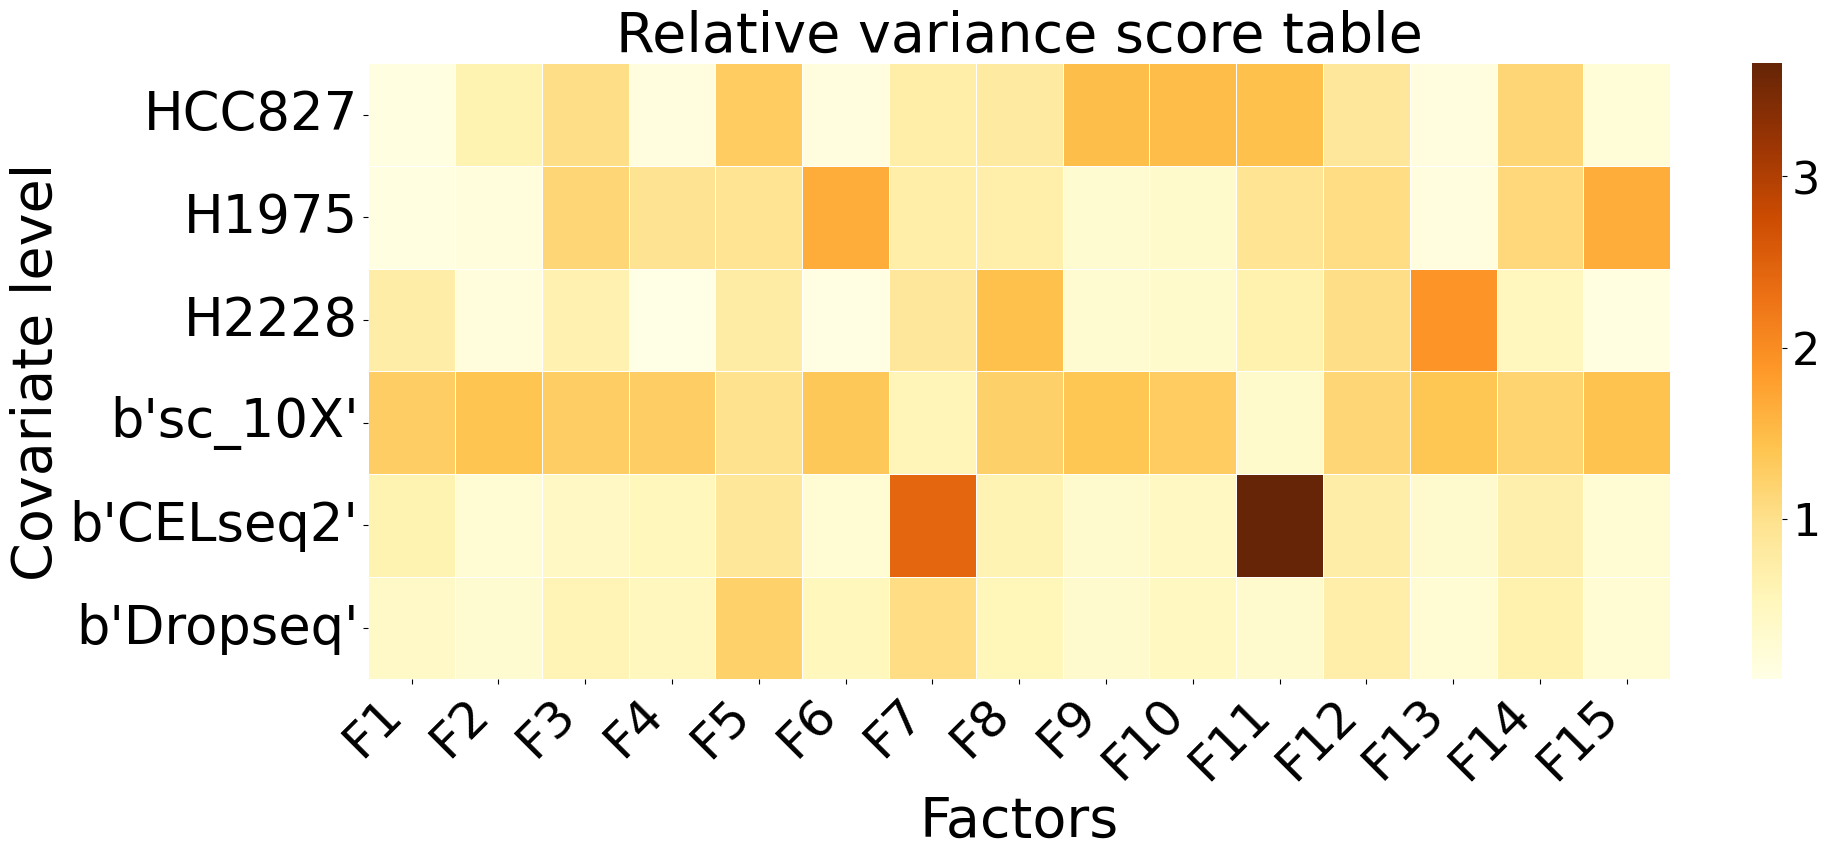

In [14]:

####################################
#### Bimodality scores
silhouette_score = met.kmeans_bimodal_score(factor_scores, time_eff=True)
bimodality_index = met.bimodality_index(factor_scores)
bimodality_score = np.mean([silhouette_score, bimodality_index], axis=0)

#### Effect size
factor_variance = met.factor_variance(factor_scores)

## Specificity
simpson_fcat = met.simpson_diversity_index(fcat)

### Homogeneity (how well-mixed the factors are given the covariate)
asv_cell_line = met.average_scaled_var(factor_scores, covariate_vector=y_cell_line, mean_type='arithmetic')
asv_sample = met.average_scaled_var(factor_scores, y_sample, mean_type='arithmetic')

#### plot the ralative variance table
svt_cell_line = met.scaled_var_table(factor_scores, y_cell_line)
svt_protocol = met.scaled_var_table(factor_scores, y_protocol)
svt = pd.concat([svt_cell_line, svt_protocol], axis=0)
vis.plot_relativeVar(svt.iloc[:,0:15], title='Relative variance score table')


<Figure size 700x1700 with 0 Axes>

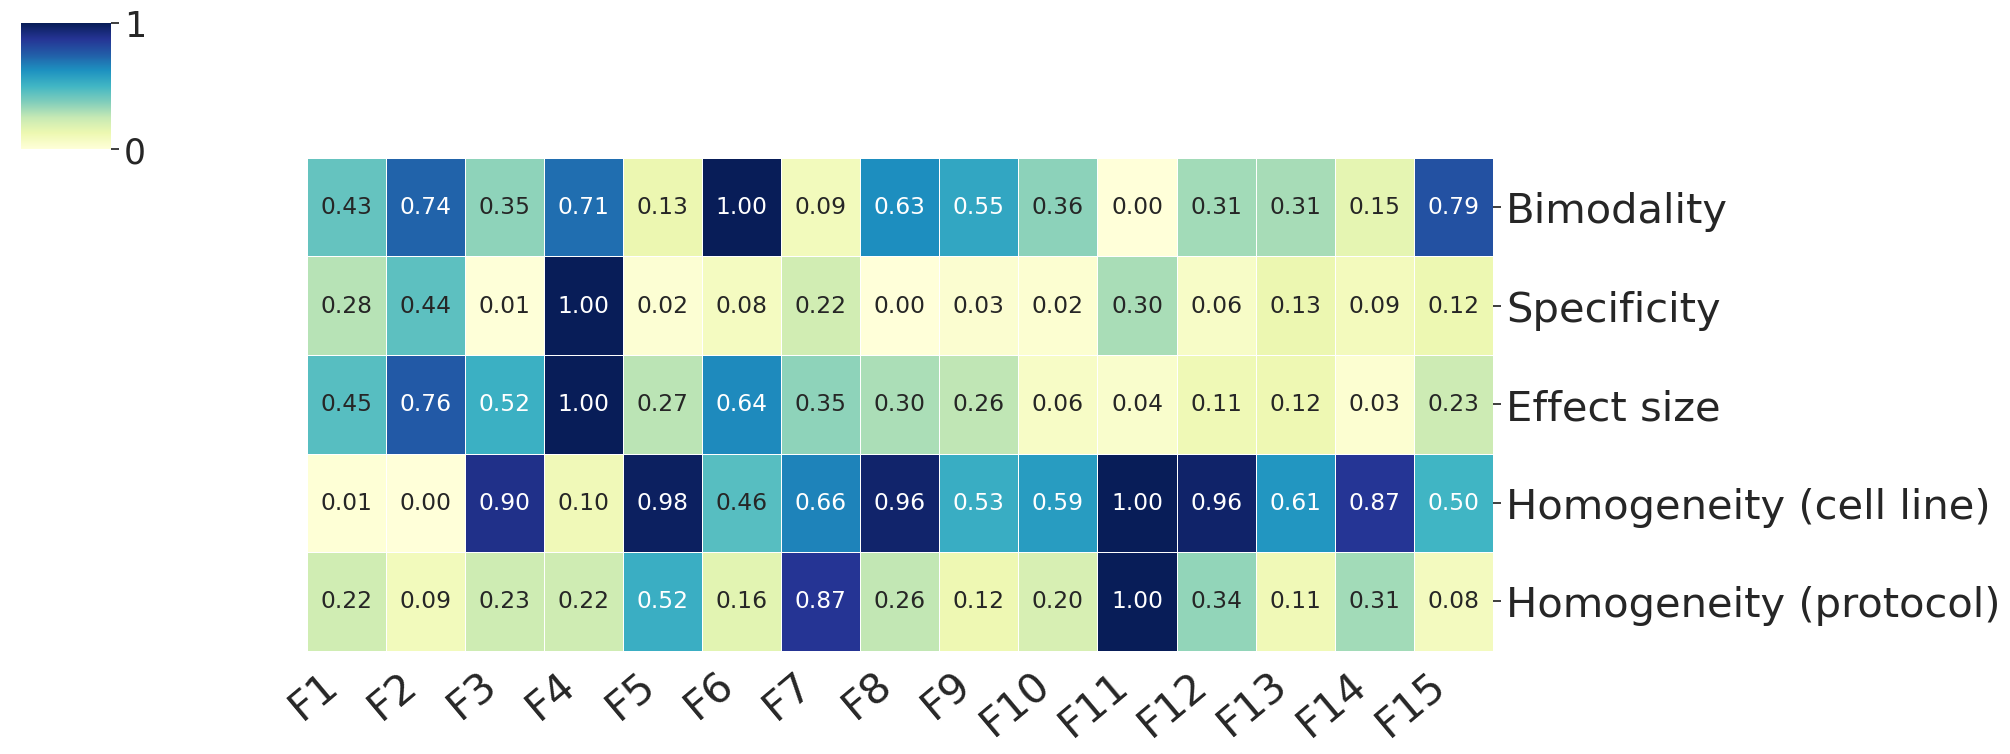

In [15]:
########### create factor-interpretibility score table (FIST) ######
metrics_dict = {'Bimodality':bimodality_score, 
                    'Specificity':simpson_fcat,
                    'Effect size': factor_variance,
                    'Homogeneity (cell line)':asv_cell_line,
                    'Homogeneity (protocol)':asv_sample}

fist = met.FIST(metrics_dict)
### subset the first 15 factors of fist dataframe
vis.plot_FIST(fist.iloc[0:15,:])